# Obstacles Detection for visually impaired Using CNN :

## Import Libraries :

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import numpy as np
import kagglehub
import torch
import random

import warnings 
warnings.filterwarnings('ignore')

/home/hamza_ok/AI-Powered Assistance System for Visually Impaired/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DataSet Download & Preprocess

In [3]:


# Download the dataset
path = kagglehub.dataset_download("idrisskh/obstacles-dataset")
full_path = path + '/obstacles dataset'

print("Path to dataset files:", full_path)

100%|██████████| 235M/235M [02:03<00:00, 1.99MB/s] 

Extracting files...


Path to dataset files: /home/hamza_ok/.cache/kagglehub/datasets/idrisskh/obstacles-dataset/versions/1/obstacles dataset


In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root=full_path + '/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root=full_path + '/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
train_dataset.classes

['chair',
 'door',
 'fence',
 'garbage_bin',
 'obstacle',
 'plant',
 'pothole',
 'stairs',
 'table',
 'vehicle']

In [4]:
def plot_class_distribution(dataset):

    # Count the occurrences of each class
    class_counts = Counter(dataset.targets)
    
    # Map class indices to class names
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Prepare data for the histogram
    class_names = [idx_to_class[i] for i in sorted(class_counts.keys())]
    counts = [class_counts[i] for i in sorted(class_counts.keys())]
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Class Distribution in Dataset', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

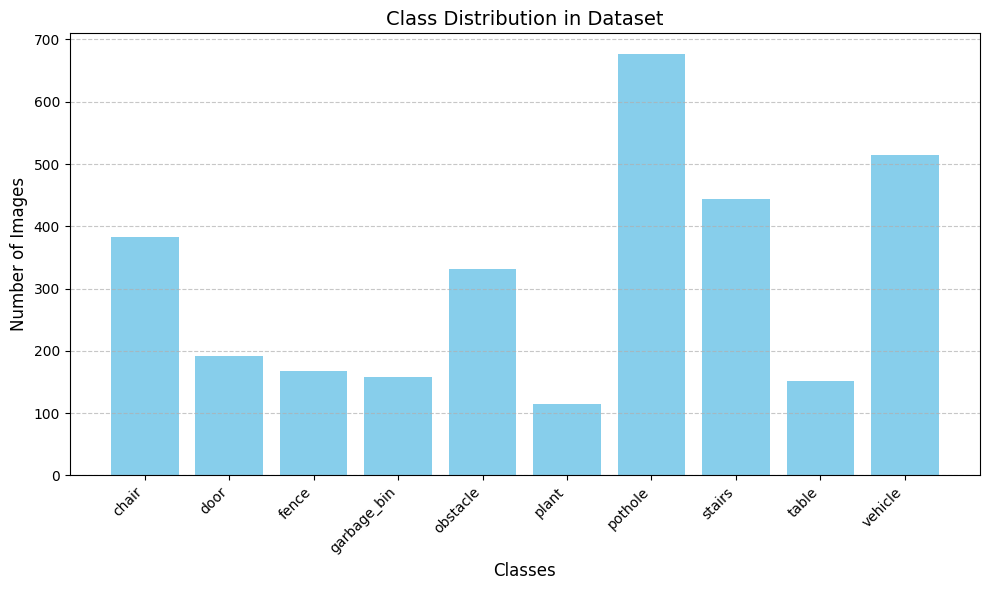

In [5]:
plot_class_distribution(train_dataset)

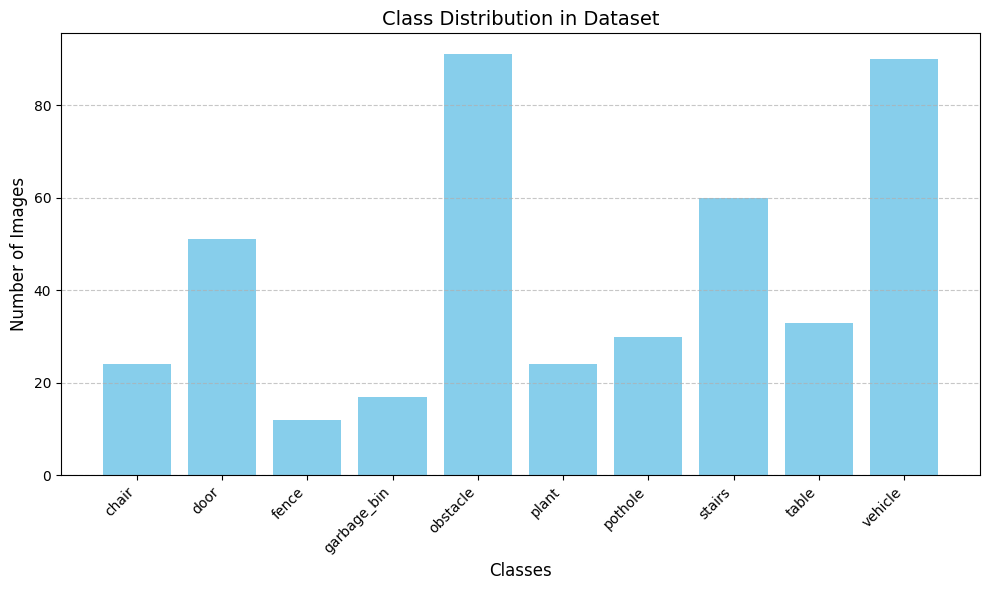

In [6]:
plot_class_distribution(val_dataset)

## CNN Model :

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 16, 16]
        
        # the fully connected layer
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## Training and Evaluation Functions :

In [8]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Shape: [batch_size, num_classes]
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
    
    return epoch_loss, accuracy, report, all_labels, all_preds

## Train and Evaluate the Model :

Epoch 1/30
Training Loss: 1.9078, Training Accuracy: 0.3372
Validation Loss: 1.7804, Validation Accuracy: 0.3565
----------------------------------------
Epoch 2/30
Training Loss: 1.4717, Training Accuracy: 0.4847
Validation Loss: 1.3688, Validation Accuracy: 0.5347
----------------------------------------
Epoch 3/30
Training Loss: 1.2417, Training Accuracy: 0.5862
Validation Loss: 1.2090, Validation Accuracy: 0.5741
----------------------------------------
Epoch 4/30
Training Loss: 1.0518, Training Accuracy: 0.6427
Validation Loss: 1.0147, Validation Accuracy: 0.6366
----------------------------------------
Epoch 5/30
Training Loss: 0.9405, Training Accuracy: 0.6849
Validation Loss: 0.9329, Validation Accuracy: 0.6620
----------------------------------------
Epoch 6/30
Training Loss: 0.7970, Training Accuracy: 0.7356
Validation Loss: 1.0080, Validation Accuracy: 0.6597
----------------------------------------
Epoch 7/30
Training Loss: 0.7064, Training Accuracy: 0.7634
Validation Loss:

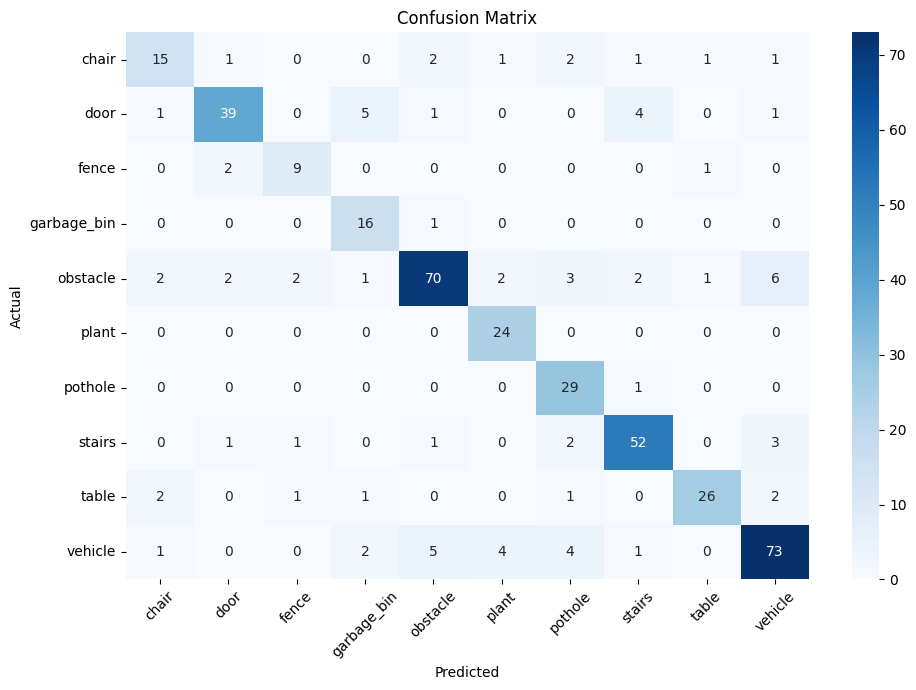

In [10]:
# Initialize model, criterion, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_preds = [], []
val_loss, val_accuracy = 0, 0
val_report = None

num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_report, all_labels, all_preds = evaluate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print('-'*40)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report (Validation):\n", val_report)
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

##  Visualizing Predictions :

In [11]:
def visualize_predictions(model, dataset, num_classes=5, device='cpu'):
    # Map class indices to names
    class_to_idx = dataset.class_to_idx  # Class to index mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    
    # Randomly sample one image per class
    sampled_images = {}
    for class_label in random.sample(list(class_to_idx.values()), num_classes):
        for i in range(len(dataset)):
            img, label = dataset[i]
            if label == class_label:
                sampled_images[class_label] = (img, label)
                break  # Stop after finding one example for the class
    
    # Prepare for predictions
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
        for ax, (class_label, (img, label)) in zip(axes, sampled_images.items()):
            # Prepare image for model
            input_img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(input_img)
            pred_label = output.argmax(dim=1).item()  # Get the predicted class index
            
            # Prepare the image for visualization
            img = img.numpy().transpose((1, 2, 0))  # Convert tensor to HxWxC format
            img = np.clip(
                img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
                0, 1
            )
            
            # Display the image
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(
                f"True: {idx_to_class[label]}\nPred: {idx_to_class[pred_label]}",
                fontsize=10,
                color="green" if label == pred_label else "red"
            )
    
    plt.tight_layout()
    plt.show()

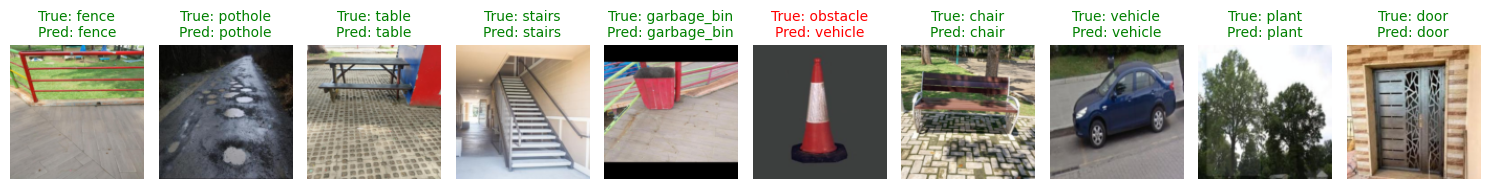

In [12]:
visualize_predictions(model, val_dataset, num_classes=10, device='cuda')

## Saving and Loading the Model

In [13]:
# Save the model
torch.save(model.state_dict(), './obstacle_detection_cnn.pth')